In [254]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import statsmodels.formula.api as smf
from practicum_utils import get_loggi_files, global_connect, run_query, explained_time, careful_query

In [255]:
db = global_connect()

In [256]:
agency = {'1': '6e7dacf2149d053183fe901e3cfd8b82', '2': '58cfe3b975dd7cbd1ac84d555640bfd9'}

In [257]:
holidays = [
    ('2019-01-01', 'New Year Day'),
    ('2019-03-04', 'Carnival'),
    ('2019-03-05', 'Carnival'),
    ('2019-05-01', 'Labour Day'),
    ('2019-09-07', 'Independece Day'),
    ('2019-12-25', 'Christmas Day'),
    ('2019-12-31', 'Last Year Day'),
    ('2020-01-01', 'New Year Day'),
    ('2020-01-25', 'Sao Paulo Birthday (no working day for agency 1)'),    
    ('2020-02-24', 'Carnival'),
    ('2020-02-25', 'Carnival')
]

In [258]:
def get_daily_drivers(agency_id, from_='2019-10-01', to_='2020-03-31'):
    
    df = careful_query("""
        select *
        from unique_drivers_daily_oozma
        where date >= '{1}'
          and date < '{2}'
          and distribution_center = '{0}'
        order by date asc 
        """.format(agency_id, from_, to_))
    
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)
    
    return df    

In [259]:
df1 = get_daily_drivers(agency['1'])
df1.head()

,drivers,drivers_alo,drivers_alo_10_days,distribution_center
date,,,,
2019-10-02,1256,484,484,6e7dacf2149d053183fe901e3cfd8b82
2019-10-03,1264,485,485,6e7dacf2149d053183fe901e3cfd8b82
2019-10-04,1352,477,477,6e7dacf2149d053183fe901e3cfd8b82
2019-10-05,561,256,256,6e7dacf2149d053183fe901e3cfd8b82
2019-10-06,329,168,168,6e7dacf2149d053183fe901e3cfd8b82


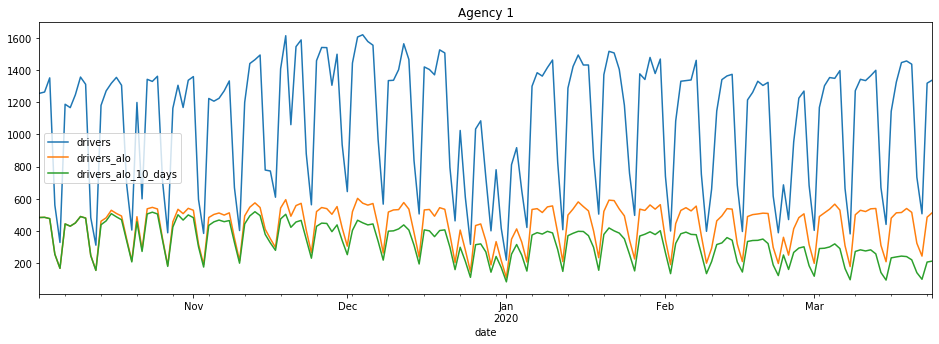

In [260]:
df1.plot(figsize=(16,5))
plt.title('Agency 1');

In [261]:
df2 = get_daily_drivers(agency['2'])
df2.head()

,drivers,drivers_alo,drivers_alo_10_days,distribution_center
date,,,,
2019-10-23,5698,1729,1729,58cfe3b975dd7cbd1ac84d555640bfd9
2019-10-24,5796,1775,1775,58cfe3b975dd7cbd1ac84d555640bfd9
2019-10-25,5713,1785,1785,58cfe3b975dd7cbd1ac84d555640bfd9
2019-10-26,2544,889,889,58cfe3b975dd7cbd1ac84d555640bfd9
2019-10-27,1396,444,444,58cfe3b975dd7cbd1ac84d555640bfd9


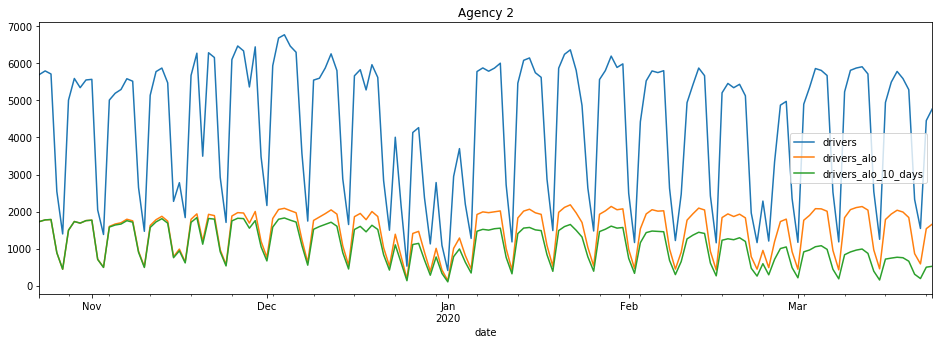

In [262]:
df2.plot(figsize=(16,5))
plt.title('Agency 2');

In [263]:
def prepare_daily_drivers_for_predictions(df, column = 'drivers'):

    # -----------------------
    # Prepare day of the week
    # -----------------------
    dow = ['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday']
    df['DOW'] = df.index.dayofweek
    df = pd.concat([df, pd.get_dummies(df['DOW'], drop_first=True)], axis=1)
    df = df.rename(columns={i : dow[i] for i in range(7)})
    del df['DOW']

    # ---------------
    # Prepare holiday
    # ---------------
    df['holiday'] = 0

    for h in [h[0] for h in holidays]:
        d = pd.to_datetime(h)
        if d in df.index:
            df.loc[d, 'holiday'] = 1

    # -------------------------------------------
    # Prepare previous number of (column) drivers
    # -------------------------------------------
    df['prev_day'] = df[column]
    df.reset_index(inplace=True)

    for i in range(1, len(df)):
        df.loc[i, 'prev_day'] = df.loc[i-1, column]
    df.set_index('date', inplace=True)
    
    return df

In [264]:
def get_daily_drivers_model(agency_id, today, column='drivers'):

    predictables = ['drivers', 'drivers_alo', 'drivers_alo_10_days']
    if column not in predictables:
        raise "ERROR"
        
    # read all
    df = get_daily_drivers(agency_id)
    
    for col in predictables:
        if col != column:
            del df[col]
    
    # prepare
    df = prepare_daily_drivers_for_predictions(df, column)
    
    train = df[df.index < pd.to_datetime(today)]
    test = df[df.index >= pd.to_datetime(today)]
    
    dates = df.index.tolist()
    dates_train = df[df.index < pd.to_datetime(today)].index.tolist()
    dates_test = df[df.index >= pd.to_datetime(today)].index.tolist()
    
    formula = 'np.sqrt({}) ~ '.format(column) + ' + '.join([col for col in df if col not in ['distribution_center', column]])
    formula = formula.replace('prev_day', 'np.sqrt(prev_day)')
    print(formula)
    model = smf.ols(formula = formula, data = train).fit()
    #print(model.summary())    

    return model, train, test, dates_train, dates_test

In [265]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       np.sqrt(drivers)   R-squared:                       0.939
Model:                            OLS   Adj. R-squared:                  0.939
Method:                 Least Squares   F-statistic:                 1.843e+04
Date:                Wed, 20 May 2020   Prob (F-statistic):               0.00
Time:                        12:43:42   Log-Likelihood:                -3357.1
No. Observations:                2403   AIC:                             6720.
Df Residuals:                    2400   BIC:                             6738.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -0.3640      0.074     -4.889      0.000      -0.510      -0.218
np.sqrt(prev_hour)          0.6843      0.010     66.340      0.000       0.664       0.705
np.sqrt(historical_avg)     0.3415      0.011     30.320      0.000       0.319       0.364
==============================================================================
Omnibus:                      282.400   Durbin-Watson:                   0.609
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1083.766
Skew:                           0.535   Prob(JB):                    4.60e-236
Kurtosis:                       6.111   Cond. No.                         71.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [266]:
def predict_daily_unique_drivers(agency_id, today, column='drivers', days=7):
    model, train, test, dates_train, dates_test = get_daily_drivers_model(agency_id, today, column)
    
    test = test.head(days)
    dates_test = dates_test[:days]
    

    t = test.copy()
    del t['distribution_center']
    t = t.reset_index()
    t[column] = 0
    t['prev_day'] = 0
    t.loc[t.index[0], 'prev_day'] = train[train.index == train.index[-1]][column].item()
    
    for i in range(len(t)):
        #print(i, np.square(model.predict(t.iloc[i]).item()))
        print('.', end='')
        p = np.square(model.predict(t.loc[t.index == t.index[i], :])).item()
        t.loc[t.index == t.index[i], column] = p
        # np.square(model.predict(t.iloc[i]).item())
        if i < len(t)-1:
            t.loc[t.index == t.index[i+1], 'prev_day'] = p
       
    test['prediction'] = np.round(pd.DataFrame({column: t[column].values}, index=dates_test)[column])
    
    return test[[column, 'prediction']]
    

In [267]:
predict_daily_unique_drivers(agency['1'], today = '2020-01-01')

np.sqrt(drivers) ~ tuesday + wednesday + thursday + friday + saturday + sunday + holiday + np.sqrt(prev_day)
.......

,drivers,prediction
date,,
2020-01-01,219,297.0
2020-01-02,812,894.0
2020-01-03,918,1132.0
2020-01-04,651,671.0
2020-01-05,422,434.0
2020-01-06,1300,1212.0
2020-01-07,1384,1218.0


np.sqrt(drivers) ~ tuesday + wednesday + thursday + friday + saturday + sunday + holiday + np.sqrt(prev_day)
..............np.sqrt(drivers) ~ tuesday + wednesday + thursday + friday + saturday + sunday + holiday + np.sqrt(prev_day)
..............

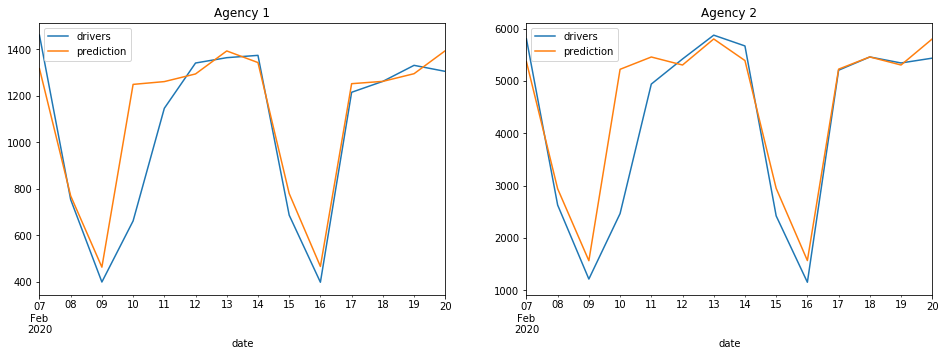

In [268]:
pred1 = predict_daily_unique_drivers(agency['1'], today = '2020-02-07', column='drivers', days=14)
pred2 = predict_daily_unique_drivers(agency['2'], today = '2020-02-07', column='drivers', days=14)

plt.figure(figsize=(16,5))
pred1.plot(ax=plt.subplot(121)).set_title('Agency 1')
pred2.plot(ax=plt.subplot(122)).set_title('Agency 2');

np.sqrt(drivers_alo) ~ tuesday + wednesday + thursday + friday + saturday + sunday + holiday + np.sqrt(prev_day)
..............np.sqrt(drivers_alo) ~ tuesday + wednesday + thursday + friday + saturday + sunday + holiday + np.sqrt(prev_day)
..............

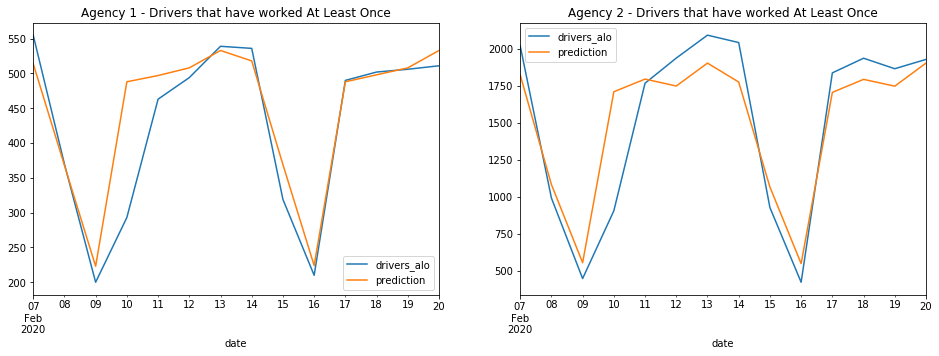

In [269]:
pred1 = predict_daily_unique_drivers(agency['1'], today = '2020-02-07', column='drivers_alo', days=14)
pred2 = predict_daily_unique_drivers(agency['2'], today = '2020-02-07', column='drivers_alo', days=14)

plt.figure(figsize=(16,5))
pred1.plot(ax=plt.subplot(121)).set_title('Agency 1 - Drivers that have worked At Least Once')
pred2.plot(ax=plt.subplot(122)).set_title('Agency 2 - Drivers that have worked At Least Once');

# Hourly

In [270]:
def get_hourly_drivers(agency_id, from_='2019-10-01', to_='2020-03-31'):
    
    df = careful_query("""
        select *
        from unique_drivers_hourly_oozma
        where date >= '{1}'
          and date < '{2}'
          and distribution_center = '{0}'
        order by date asc 
        """.format(agency_id, from_, to_))
    
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)
    
    return df    

In [271]:
df1 = get_hourly_drivers(agency['1'], from_='2019-11-12', to_='2019-11-14')
df1.head()

,drivers,drivers_alo,drivers_alo_10_days,distribution_center
date,,,,
2019-11-12 00:00:00,71,43,41,6e7dacf2149d053183fe901e3cfd8b82
2019-11-12 01:00:00,59,35,33,6e7dacf2149d053183fe901e3cfd8b82
2019-11-12 02:00:00,54,34,32,6e7dacf2149d053183fe901e3cfd8b82
2019-11-12 03:00:00,49,31,30,6e7dacf2149d053183fe901e3cfd8b82
2019-11-12 04:00:00,55,30,28,6e7dacf2149d053183fe901e3cfd8b82


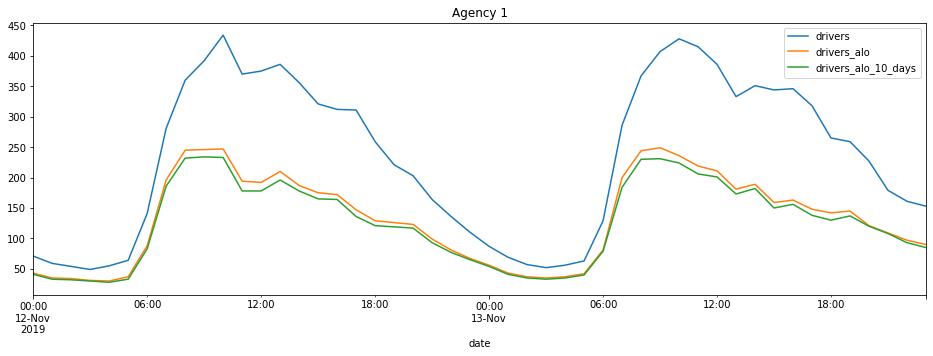

In [272]:
df1.plot(figsize=(16,5))
plt.title('Agency 1');

In [273]:
def prepare_hourly_drivers_for_predictions(df, today_time, column = 'drivers'):

    df['prev_hour'] = df[column]
    df.reset_index(inplace=True)
    
    if len(today_time) == 10:
        today_time += ' 00'

    for i in range(1, len(df)):
        df.loc[i, 'prev_hour'] = df.loc[i-1, column]

    df.set_index('date', inplace=True)
    
    avg_per_dow_and_hour = []
    for i in range(7):
        condition = (df.index.dayofweek == i)
        if len(today_time) > 0:
            condition = condition & (df.index < today_time[:13])
        
        if len(df[condition]) == 0:
            raise 'There is not enough data to build the hourly prediction model'
        avg_per_dow_and_hour.append(
            df[condition].groupby(df[condition].index.hour)[column].mean().reset_index(drop=True)
        )
    #print(avg_per_dow_and_hour)
    
    df['historical_avg'] = 0
    for day in range(7):
        for hour in range(24):
            df.loc[(df.index.dayofweek == day)
                & (df.index.hour == hour), 'historical_avg'] = avg_per_dow_and_hour[day][hour]
    
    return df

In [274]:
df1 = get_hourly_drivers(agency['1'], from_='2019-10-02', to_='2020-03-14')
prepare_hourly_drivers_for_predictions(df1, today_time = '2020-02-20 15:27:30', column='drivers')

,drivers,drivers_alo,drivers_alo_10_days,distribution_center,prev_hour,historical_avg
date,,,,,,
2019-10-02 00:00:00,106,68,68,6e7dacf2149d053183fe901e3cfd8b82,106,94.095238
2019-10-02 01:00:00,95,57,57,6e7dacf2149d053183fe901e3cfd8b82,106,79.428571
2019-10-02 02:00:00,78,49,49,6e7dacf2149d053183fe901e3cfd8b82,95,71.523810
2019-10-02 03:00:00,78,49,49,6e7dacf2149d053183fe901e3cfd8b82,78,69.666667
2019-10-02 04:00:00,76,43,43,6e7dacf2149d053183fe901e3cfd8b82,78,72.428571
...,...,...,...,...,...,...
2020-03-13 19:00:00,211,138,78,6e7dacf2149d053183fe901e3cfd8b82,242,221.700000
2020-03-13 20:00:00,200,126,70,6e7dacf2149d053183fe901e3cfd8b82,211,197.900000
2020-03-13 21:00:00,172,105,54,6e7dacf2149d053183fe901e3cfd8b82,200,169.600000


In [275]:
def get_hourly_drivers_model(agency_id, today_time, column='drivers'):

    predictables = ['drivers', 'drivers_alo', 'drivers_alo_10_days']
    if column not in predictables:
        raise "ERROR"
        
    # read all
    # TODO: this is not necessary
    df = get_hourly_drivers(agency_id)
    
    for col in predictables:
        if col != column:
            del df[col]
    
    # prepare
    df = prepare_hourly_drivers_for_predictions(df, today_time, column)
    
    train = df[df.index < pd.to_datetime(today_time)]
    test = df[df.index >= pd.to_datetime(today_time)]
    
    dates = df.index.tolist()
    dates_train = df[df.index < pd.to_datetime(today_time)].index.tolist()
    dates_test = df[df.index >= pd.to_datetime(today_time)].index.tolist()
    
    formula = 'np.sqrt({}) ~ '.format(column) + ' + '.join([col for col in df if col not in ['distribution_center', column]])
    formula = formula.replace('prev_hour', 'np.sqrt(prev_hour)')
    formula = formula.replace('historical_avg', 'np.sqrt(historical_avg)')
    print(formula)
    model = smf.ols(formula = formula, data = train).fit()
    #print(model.summary())    

    return model, train, test, dates_train, dates_test

In [276]:
model, train, test, dates_train, dates_test = get_hourly_drivers_model(agency['1'], today_time='2020-01-10 15:30:20' , column='drivers')

np.sqrt(drivers) ~ np.sqrt(prev_hour) + np.sqrt(historical_avg)


In [277]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       np.sqrt(drivers)   R-squared:                       0.939
Model:                            OLS   Adj. R-squared:                  0.939
Method:                 Least Squares   F-statistic:                 1.843e+04
Date:                Wed, 20 May 2020   Prob (F-statistic):               0.00
Time:                        12:43:48   Log-Likelihood:                -3357.1
No. Observations:                2403   AIC:                             6720.
Df Residuals:                    2400   BIC:                             6738.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -0.3640      0.074     -4.889      0.000      -0.510      -0.218
np.sqrt(prev_hour)          0.6843      0.010     66.340      0.000       0.664       0.705
np.sqrt(historical_avg)     0.3415      0.011     30.320      0.000       0.319       0.364
==============================================================================
Omnibus:                      282.400   Durbin-Watson:                   0.609
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1083.766
Skew:                           0.535   Prob(JB):                    4.60e-236
Kurtosis:                       6.111   Cond. No.                         71.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [278]:
def predict_hourly_unique_drivers(agency_id, today_time, column='drivers', hours=48):
    model, train, test, dates_train, dates_test = get_hourly_drivers_model(agency_id, today_time , column)
    
    test = test.head(hours)
    dates_test = dates_test[:hours]
    

    t = test.copy()
    del t['distribution_center']
    t = t.reset_index()
    t[column] = 0
    t['prev_hour'] = 0
    t.loc[t.index[0], 'prev_hour'] = train[train.index == train.index[-1]][column].item()
    
    for i in range(len(t)):
        #print(i, np.square(model.predict(t.iloc[i]).item()))
        print('.', end='')
        p = np.square(model.predict(t.loc[t.index == t.index[i], :])).item()
        t.loc[t.index == t.index[i], column] = p
        if i < len(t)-1:
            t.loc[t.index == t.index[i+1], 'prev_hour'] = p
       
    test['prediction'] = np.round(pd.DataFrame({column: t[column].values}, index=dates_test)[column])
    
    return test[[column, 'prediction']]


In [279]:
predict_hourly_unique_drivers(agency['1'], today_time = '2020-01-10 15:30:27')

np.sqrt(drivers) ~ np.sqrt(prev_hour) + np.sqrt(historical_avg)
................................................

,drivers,prediction
date,,
2020-01-10 16:00:00,350,314.0
2020-01-10 17:00:00,323,299.0
2020-01-10 18:00:00,300,280.0
2020-01-10 19:00:00,274,257.0
2020-01-10 20:00:00,249,233.0
2020-01-10 21:00:00,224,208.0
2020-01-10 22:00:00,196,184.0
2020-01-10 23:00:00,156,160.0
2020-01-11 00:00:00,140,135.0


np.sqrt(drivers) ~ np.sqrt(prev_hour) + np.sqrt(historical_avg)
........................np.sqrt(drivers) ~ np.sqrt(prev_hour) + np.sqrt(historical_avg)
........................

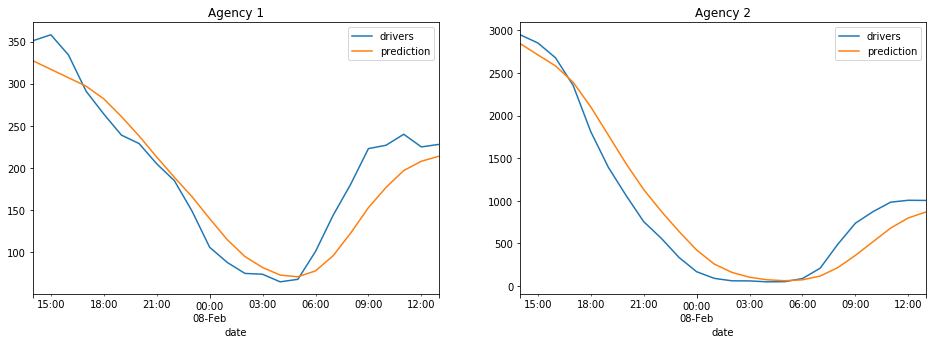

In [280]:
pred1 = predict_hourly_unique_drivers(agency['1'], today_time = '2020-02-07 13:56', column='drivers', hours=24)
pred2 = predict_hourly_unique_drivers(agency['2'], today_time = '2020-02-07 13:56', column='drivers', hours=24)

plt.figure(figsize=(16,5))
pred1.plot(ax=plt.subplot(121)).set_title('Agency 1')
pred2.plot(ax=plt.subplot(122)).set_title('Agency 2');

np.sqrt(drivers_alo) ~ np.sqrt(prev_hour) + np.sqrt(historical_avg)
................................................np.sqrt(drivers_alo) ~ np.sqrt(prev_hour) + np.sqrt(historical_avg)
................................................

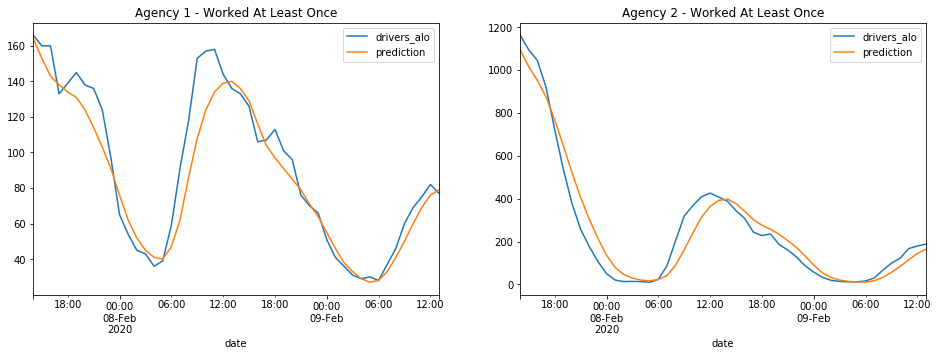

In [281]:
pred1 = predict_hourly_unique_drivers(agency['1'], today_time = '2020-02-07 13:56', column='drivers_alo', hours=48)
pred2 = predict_hourly_unique_drivers(agency['2'], today_time = '2020-02-07 13:56', column='drivers_alo', hours=48)

plt.figure(figsize=(16,5))
pred1.plot(ax=plt.subplot(121)).set_title('Agency 1 - Worked At Least Once')
pred2.plot(ax=plt.subplot(122)).set_title('Agency 2 - Worked At Least Once');

In [291]:
def get_hourly_day_itineraries(agency_id, today_time):
    
    today = today_time[:10]
    #today_date = datetime.strptime(today, '%Y-%m-%d')    
    #tomorrow_date = today_date + timedelta(days=1) 
    #tomorrow = str(tomorrow_date)[:10]
    
    df = careful_query("""
        select * from pending_oozma
        where date_time >= '{1}'
          and date_time <  '{2}'
          and distribution_center = '{0}'
        --group by distribution_center, date_time
        order by date_time asc
        """.format(agency_id, today, today_time))
    

    df.set_index('date_time', drop=True, inplace=True)
    
    return df

In [292]:
pd.date_range(start='2019-10-01', end='2019-10-08') 

DatetimeIndex(['2019-10-01', '2019-10-02', '2019-10-03', '2019-10-04',
               '2019-10-05', '2019-10-06', '2019-10-07', '2019-10-08'],
              dtype='datetime64[ns]', freq='D')

In [300]:
df = careful_query("""
    select date(created_time) as date, count(distinct(itinerary_id)) as itineraries
    from itinerary
    where created_time >= '{1}'
      and created_time < '{2}'
      and distribution_center = '{0}'
    group by date(created_time)
    order by date asc 
    """.format(agency['1'], '2019-10-03', '2019-10-20'))

index = pd.date_range(start='2019-10-03', end='2019-10-20') 
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df = pd.concat([df, pd.DataFrame(index=index)], axis=1).fillna(0)

df

,itineraries
2019-10-03,121.0
2019-10-04,43.0
2019-10-05,0.0
2019-10-06,0.0
2019-10-07,159.0
2019-10-08,188.0
2019-10-09,182.0
2019-10-10,176.0
2019-10-11,98.0
2019-10-12,0.0


In [323]:

df = df.reset_index().rename(columns={'index':'date'}).set_index('date', drop=True)

In [324]:
df

,itineraries
date,
2019-10-03,121.0
2019-10-04,43.0
2019-10-05,0.0
2019-10-06,0.0
2019-10-07,159.0
2019-10-08,188.0
2019-10-09,182.0
2019-10-10,176.0
2019-10-11,98.0
